In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Model import KMeans
from matplotlib.patches import Circle
import pandas as pd

In [8]:
def plot_kmeans_clusters(X, centroids, labels, nstd=2, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    for i in range(centroids.shape[0]):
        points_in_cluster = X[labels == i]
        if points_in_cluster.shape[0] > 0:
            avg_distance = np.mean(np.sqrt(np.sum((points_in_cluster - centroids[i])**2, axis=1)))
            circle = Circle(centroids[i], avg_distance * nstd, color='red', fill=False, linestyle='--', linewidth=2)
            ax.add_patch(circle)

    return ax


In [3]:
def normalization(data):
    demean = data - data.mean()
    unit_variance = demean / data.std()
    return unit_variance

In [4]:
def load_data(dataset_path):
    data = pd.read_csv("Datasets/"+ dataset_path)
    y_true = data['class']
    data = data.drop('class', axis=1)
    return data, y_true

In [5]:
def destandardize(data, mean, std):
    return data * std + mean

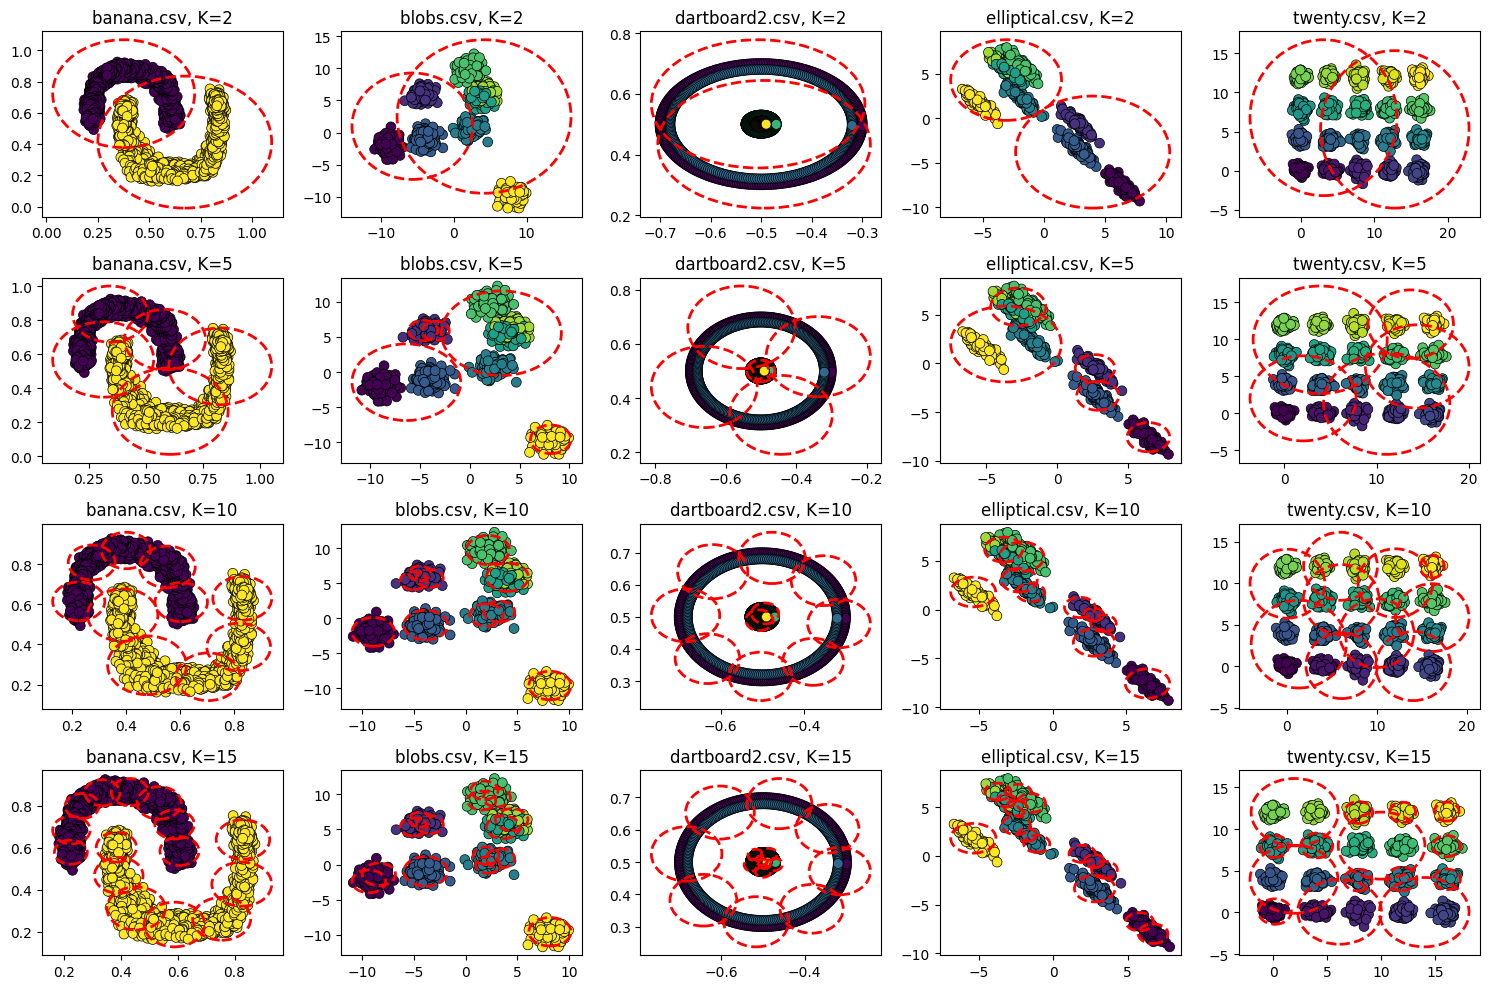

In [9]:
datasets_path = ['banana.csv','blobs.csv','dartboard2.csv','elliptical.csv','twenty.csv']
datasets = []
metrics = []
for dataset_path in datasets_path:
    data, labels = load_data(dataset_path)
    metrics.append((data.mean(),data.std()))
    data = normalization(data)
    datasets.append((data,labels))
    
k_values = [2,5,10,15]


fig, axs = plt.subplots(len(k_values), len(datasets), figsize=(15, 10))

for i, k in enumerate(k_values):
    for j, (dataset, labels) in enumerate(datasets):
        kmeans = KMeans(k, random_state=42)
        y_pred = kmeans.fit_predict(np.array(dataset))

        original_dataset = destandardize(dataset, metrics[j][0], metrics[j][1])

        org_means = np.array(metrics[j][0])
        org_stds = np.array(metrics[j][1])
        centroids = destandardize(kmeans.centroids, org_means, org_stds)

        # Plotting
        axs[i, j].scatter(original_dataset.iloc[:, 0], original_dataset.iloc[:, 1], c=labels, cmap='viridis', s=50, edgecolors='k', linewidth=0.5)
        plot_kmeans_clusters(np.array(original_dataset), np.array(centroids), y_pred, ax=axs[i, j])
        axs[i, j].set_title(f'{datasets_path[j]}, K={k}')

plt.tight_layout()
plt.show()


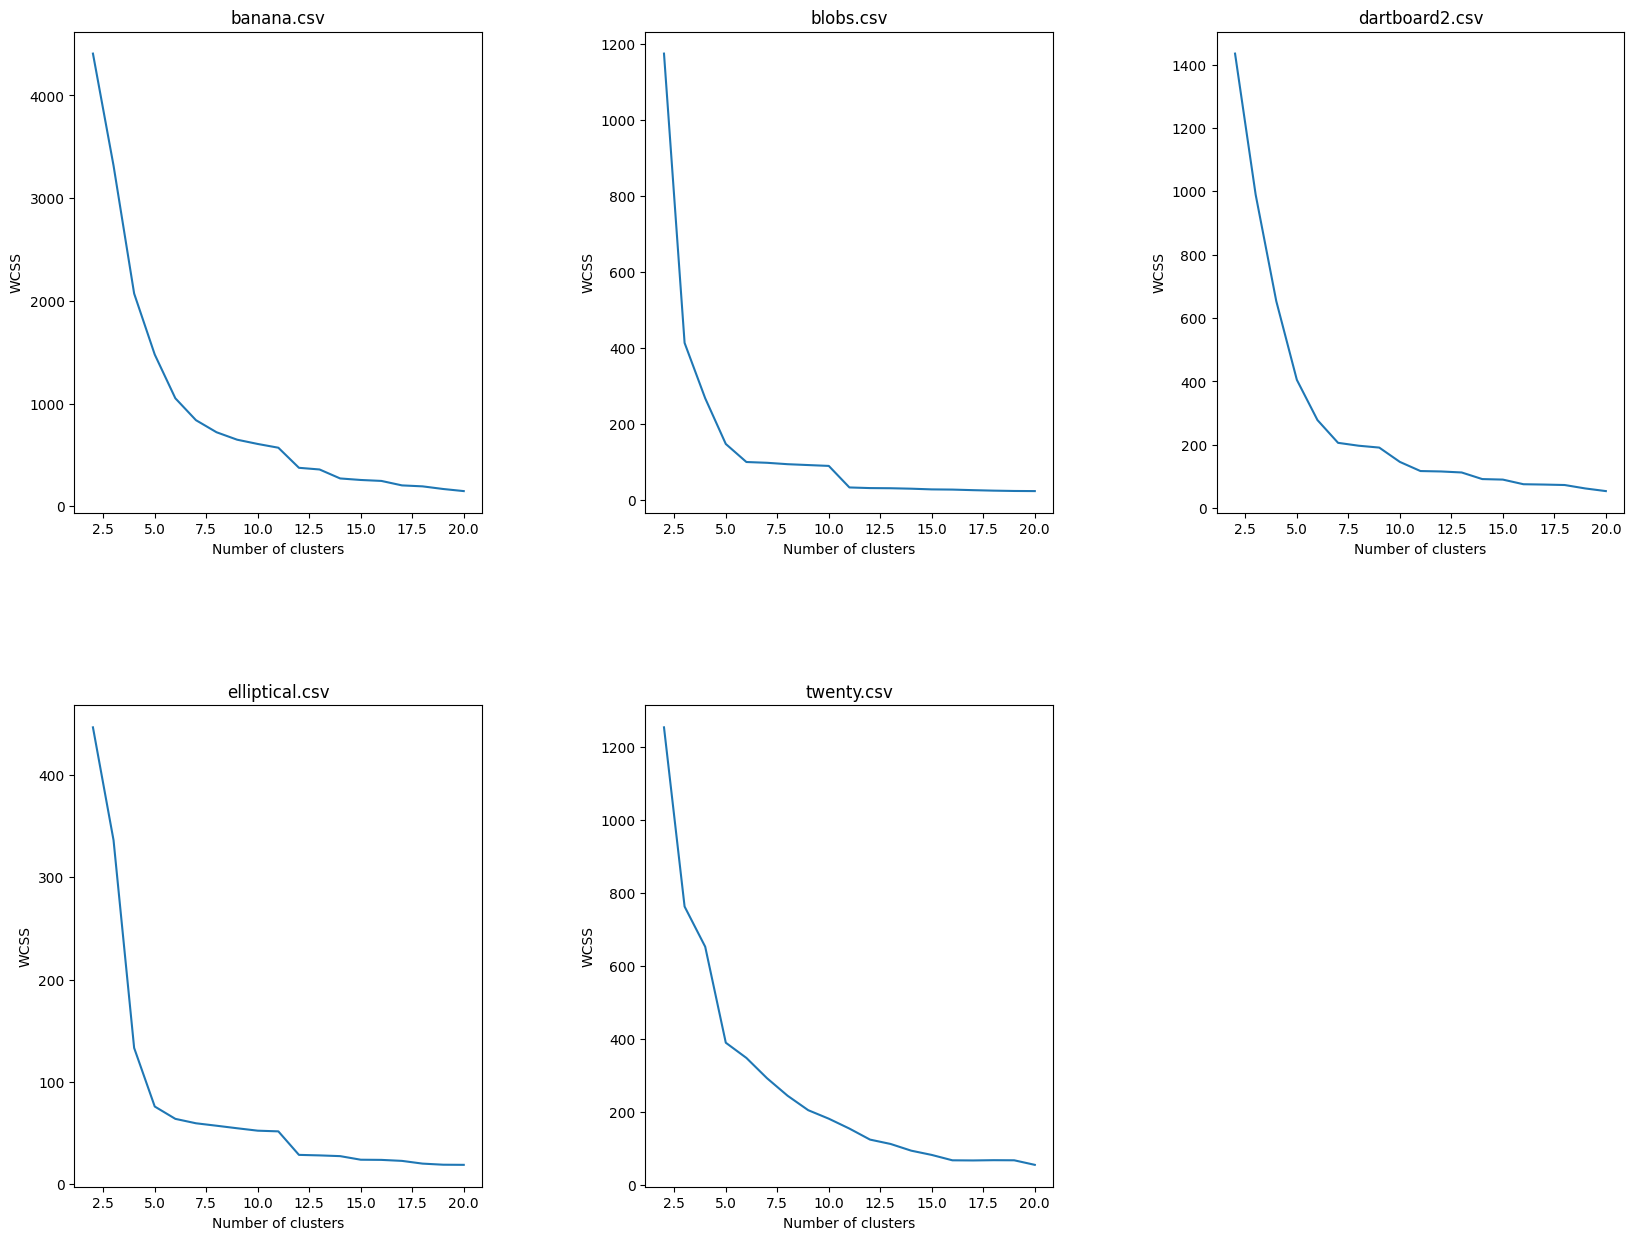

In [22]:
num_datasets = len(datasets)
num_rows = int(np.ceil(num_datasets / 3))  

fig, axs = plt.subplots(num_rows, 3, figsize=(20, 15))  
fig.subplots_adjust(hspace=0.4, wspace=0.4)  

for i, (dataset, y_true) in enumerate(datasets):
    wcss = []
    for k in range(2, 21):  
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=0)
        kmeans.fit(np.array(dataset))
        wcss.append(kmeans.inertia_)

    row_idx = i // 3
    col_idx = i % 3
    axs[row_idx, col_idx].plot(list(range(2, 21)), wcss)
    axs[row_idx, col_idx].set_title(f'{datasets_path[i]}')
    axs[row_idx, col_idx].set_xlabel('Number of clusters')
    axs[row_idx, col_idx].set_ylabel('WCSS')

for j in range(i + 1, num_rows * 3):
    axs[j // 3, j % 3].axis('off')

plt.show()